In [1]:
import sys
import localSettings as ls
print(ls.main_path)

/home/david/data/searchingfornues/v08_00_00_25/cc0pinp/1115/


In [2]:
main_path = ls.main_path
sys.path.append(main_path)

In [3]:
SHRCALIBFACTOR = 1.00

In [4]:
# USING BDT?
USEBDT = True

In [5]:
# Doing Run3?
ISRUN3 = True

In [6]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)


import awkward

In [9]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

BNB = ""
EXT = ""
NU  = ""
NUE = ""
DRT = ""
PI0 = ""

if ISRUN3:
    BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_G1_beam_good_reco2_1e19'
    EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_G1_all_reco2'
    NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2'
    NUE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2'
    DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2'
    PI0 = 'prodgenie_nc_pi0_uboone_overlay_mcc9.1_v08_00_00_26_run3_G_reco2'
else:
    BNB = 'run1_beam_on_cc0pinp'
    EXT = 'run1_beam_off_cc0pinp'
    NU  = 'run1_bnb_nu_cc0pinp'
    NUE = 'run1_bnb_nue_cc0pinp'
    DRT = 'run1_bnb_dirt_cc0pinp'
    PI0 = 'run1_bnb_ncpi0_cc0pinp'
    
mc = uproot.open(ls.ntuple_path+NU+".root")[fold][tree]
nc = uproot.open(ls.ntuple_path+PI0+".root")[fold][tree]
nue = uproot.open(ls.ntuple_path+NUE+".root")[fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[fold][tree]
ext = uproot.open(ls.ntuple_path+EXT+".root")[fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[fold][tree]
lee = uproot.open(ls.ntuple_path+NUE+".root")[fold][tree]

uproot_v = [lee,mc,nc,nue,ext,data,dirt]

variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "shr_pfp_id_v", "category", "shr_tkfit_dedx_Y", 
    #"shr_energy_tot", 
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    "crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy2",
    "run","sub","evt",
    "CosmicIP",
    #"trk_pfp_id",
    "shrmoliereavg","shrmoliererms",
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
    "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
    "trkshrhitdist0","trkshrhitdist1","trkshrhitdist2", # distance between track and shower in 2D
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trk_llr_pid_score_v", # trk-PID score
    "pi0_gammadot","pi0_mass_Y","pi0_energy2_Y", # pi0 tagger variables
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "npi0", "gamma1_edep", "gamma2_edep", "topological_score",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z","contained_fraction"
]

if not ISRUN3:
    variables.remove("_closestNuCosmicDist")
    variables.remove("crtveto")
    variables.remove("crthitpe")

nue = nue.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
mc = mc.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
nc = nc.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
data = data.pandas.df(variables, flatten=False)
ext = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables + ["weightSpline", "weightsGenie", "weightsFlux", "weightsReint"], flatten=False)
lee = lee.pandas.df(variables + ["weightSpline", "leeweight"], flatten=False)

In [10]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

df_v = [lee,mc,nc,nue,ext,data,dirt]
#df_v = [lee,mc,nue,ext,data,dirt]

for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([j[0][j[1]] if j[1]<len(j[0]) else 9999. for j in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']

In [11]:
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + 0.030) / 0.79 + df["trk_energy_tot"]
    df["reco_e_qe"] = 0.938*((df["shr_energy"]+0.030)/0.79)/(0.938 - ((df["shr_energy"]+0.030)/0.79)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: overflow encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
lee["is_signal"] = lee["category"] == 11
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11
nc["is_signal"] = nc["category"] == 11

lee.loc[lee['category'] == 1, 'category'] = 111
lee.loc[lee['category'] == 10, 'category'] = 111
lee.loc[lee['category'] == 11, 'category'] = 111

if (USEBDT == True):
    train_nc, nc = train_test_split(nc, test_size=0.5, random_state=1990)
    train_mc, mc = train_test_split(mc, test_size=0.5, random_state=1990)
    train_nue, nue = train_test_split(nue, test_size=0.5, random_state=1990)
    train_lee, lee = train_test_split(lee, test_size=0.5, random_state=1990)
    train_ext, ext = train_test_split(ext, test_size=0.5, random_state=1990)

In [13]:
# variables to be trained on
TRAINVAR = ['tksh_angle',"shr_tkfit_dedx_Y","n_showers_contained","shr_score","tksh_distance",\
            "trkfit","trkpid","subcluster","shrmoliereavg","shrmoliererms","trkshrhitdist2",\
            "hits_ratio"]#,"reco_e_rqe"]

In [14]:
if (USEBDT == True):
    for label, bkg_query in zip(nue_booster.labels, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            mc[label+"_score"] = booster.predict(
                xgb.DMatrix(mc[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nue[label+"_score"] = booster.predict(
                xgb.DMatrix(nue[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ext[label+"_score"] = booster.predict(
                xgb.DMatrix(ext[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            data[label+"_score"] = booster.predict(
                xgb.DMatrix(data[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            dirt[label+"_score"] = booster.predict(
                xgb.DMatrix(dirt[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            lee[label+"_score"] = booster.predict(
                xgb.DMatrix(lee[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nc[label+"_score"] = booster.predict(
                xgb.DMatrix(nc[TRAINVAR]),
                ntree_limit=booster.best_iteration)
    TRAINVAR = ["%s_score" % l for l in nue_booster.labels]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [15]:
if (USEBDT == True):
    with open(ls.pickle_path+'booster.pickle', 'rb') as booster_file:
        booster = pickle.load(booster_file)
        mc["global_score"] = booster.predict(
            xgb.DMatrix(mc[TRAINVAR]),
            ntree_limit=booster.best_iteration)
        nue["global_score"] = booster.predict(
            xgb.DMatrix(nue[TRAINVAR]),
            ntree_limit=booster.best_iteration)
        ext["global_score"] = booster.predict(
            xgb.DMatrix(ext[TRAINVAR]),
            ntree_limit=booster.best_iteration)
        data["global_score"] = booster.predict(
            xgb.DMatrix(data[TRAINVAR]),
            ntree_limit=booster.best_iteration)
        dirt["global_score"] = booster.predict(
            xgb.DMatrix(dirt[TRAINVAR]),
            ntree_limit=booster.best_iteration)
        lee["global_score"] = booster.predict(
            xgb.DMatrix(lee[TRAINVAR]),
            ntree_limit=booster.best_iteration)
        nc["global_score"] = booster.predict(
            xgb.DMatrix(nc[TRAINVAR]),
            ntree_limit=booster.best_iteration)

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [16]:
dfbdt_v = [lee,mc,nc,nue,ext,data,dirt]

In [17]:
samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "ext": ext,
    "dirt": dirt,
    "nc": nc,
    "lee": lee
}

scaling = 1.# 132.0/0.779

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.

#''' 1115
if ISRUN3:
    weights = {
        "mc": 0.00705 * SPLIT * scaling,
        "nue": 0.0001 * SPLIT * scaling,
        "ext": 0.0139 * SPLIT * scaling,
        "dirt": 0.024 * scaling,
        "lee": 0.0001 * SPLIT * scaling,
        "nc": 0.00337 * SPLIT * scaling,
    }
    pot = 0.779e19
else:
    weights = {
        "mc": 0.056 * SPLIT * scaling,
        "nue": 0.00074 * SPLIT * scaling,
        "ext": 0.14 * SPLIT * scaling,
        "dirt": 0.14 * scaling,
        "lee": 0.00074 * SPLIT * scaling,
        "nc": 0.0169 * SPLIT * scaling,
    }
    pot = 3.9e19
#'''
my_plotter = plotter.Plotter(samples, weights, pot=pot)

In [ ]:
# giuseppe's box cuts
QUERY = "selected == 1"
QUERY += " and (crtveto!=1 or crthitpe < 100.) and (_closestNuCosmicDist > 20.)"
QUERY += " and (reco_nu_vtx_x>20 & reco_nu_vtx_x<230) "
QUERY += " and (reco_nu_vtx_y>-95 & reco_nu_vtx_y<95)"
QUERY += " and n_showers_contained==1"
QUERY += " and shr_energy_tot_cali>0.08"
QUERY += " and hits_y>50"
QUERY += " and hits_ratio>0.65"
QUERY += " and CosmicIP>30"
QUERY += " and shr_distance<2.5"
QUERY += " and trk_distance<2.5"
QUERY += " and tksh_distance<2"
QUERY += " and tksh_angle>-0.9"
QUERY += " and (shr_tkfit_dedx_Y>0.5 & shr_tkfit_dedx_Y<3.5)"
QUERY += " and shr_score<0.125"
QUERY += " and trk_score>0.85"
QUERY += " and slclustfrac>0.6"
#QUERY += " and reco_e_rqe>0.8"

In [20]:
# muon selection
QUERY = 'nslice == 1'
if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'
QUERY += ' and trk_len > 20'
QUERY += ' and topological_score > 0.06'
QUERY += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251'
QUERY += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110'
QUERY += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986'


#QUERY += ' and bkpdg == 2212 and (trkcompl < 0.5 or trkpur < 0.5)'

print (QUERY)

nslice == 1 and (crtveto!=1) and (_closestNuCosmicDist > 20.) and trk_len > 20 and topological_score > 0.06 and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986


In [ ]:
# nue pre-selection w/ CRT
QUERY = 'nslice == 1' # cut # 1
QUERY += ' and selected == 1'
if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'
QUERY += ' and shr_energy_tot_cali > 0.07'
QUERY += ' and n_tracks_contained > 0'

# in case you do not want to look at the data
QUERY += ' and bnbdata==0'

#QUERY += ' and n_showers_contained > 1'

# Loose box cuts
QUERY += ' and tksh_distance < 5.0'
QUERY += ' and shr_tkfit_dedx_Y < 4.0 and shr_tkfit_dedx_Y > 0'
QUERY += ' and tksh_angle > -0.9 and tksh_angle < 0.9'
QUERY += ' and trkpid < 0.0'
QUERY += ' and shr_score < 0.30'
QUERY += ' and hits_ratio>0.6'
QUERY += ' and n_showers_contained < 2'
QUERY += ' and CosmicIP > 20.'

# Box cuts

#QUERY += ' and tksh_distance < 3.0'
#QUERY += ' and shr_tkfit_dedx_Y < 3.0 and shr_tkfit_dedx_Y > 1.5'
#QUERY += ' and tksh_angle > -0.9 and tksh_angle < 0.7'
#QUERY += ' and trkfit < 0.4'
#QUERY += ' and shrmoliereavg < 10'
#QUERY += ' and trkpid < 0.0'
#QUERY += ' and n_showers_contained < 2'
#QUERY += ' and shr_score < 0.15'
#QUERY += ' and hits_ratio>0.75'
# the ones below are not needed after those above
###QUERY += ' and reco_nu_vtx_x<230 & reco_nu_vtx_y<90'
###QUERY += ' and CosmicIP > 20.'
###QUERY += ' and reco_e_rqe>0.7'
###QUERY += ' and subcluster > 7'
###QUERY += ' and trkshrhitdist2 < 1.0'
###QUERY += ' and shrmoliererms < 2000'

# BDT cuts

#BDTCUT = 0.85

QUERY += ' and ccpi0_score > 0.95'
QUERY += ' and ncpi0_score > 0.95'
QUERY += ' and cc_score > 0.95'
QUERY += ' and ext_score > 0.95'
QUERY += ' and cosmic_score > 0.95'

#QUERY += ' and shr_score < 0.2'
#QUERY += ' and shr_tkfit_dedx_Y < 4.0'
#QUERY += ' and hits_ratio>0.7 and slclustfrac>0.'
#QUERY += ' and reco_nu_vtx_x<230 & reco_nu_vtx_y<90'
#QUERY += ' and reco_e_rqe>0.5'
#QUERY += ' and cc_score>0.8'
#QUERY += ' and ccpi0_score>0.87'
#QUERY += ' and cosmic_score>0.85'

In [28]:
# create output files based on selection
fname_v = [NUE,NU,PI0,NUE,EXT,BNB,DRT]

for i,name in enumerate(fname_v):
    if (i == 0):
        continue # skip LEE event. This one will be done within SBNFit
        
    df = dfbdt_v[i]

    fout = open(ls.ntuple_path+name+'.txt','w')
    dfsel = df.query(QUERY)
    print ('file %s has %i selected entries'%(name,dfsel.shape[0]))
    for i,row in dfsel.iterrows():
        run = row['run'].values[0]
        sub = row['sub'].values[0]
        evt = row['evt'].values[0]
        fout.write('%i %i %i \n'%(run,sub,evt))
    fout.close()

file prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2 has 43749 selected entries
file prodgenie_nc_pi0_uboone_overlay_mcc9.1_v08_00_00_26_run3_G_reco2 has 3073 selected entries
file prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2 has 14333 selected entries
file data_extbnb_mcc9.1_v08_00_00_25_reco2_G1_all_reco2 has 1751 selected entries
file data_bnb_mcc9.1_v08_00_00_25_reco2_G1_beam_good_reco2_1e19 has 847 selected entries
file prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2 has 669 selected entries


Profile likelihood: 0.06 sigma @ 1.32e21 POT
s/sqrt(b): 0.06 sigma @ 1.32e21 POT


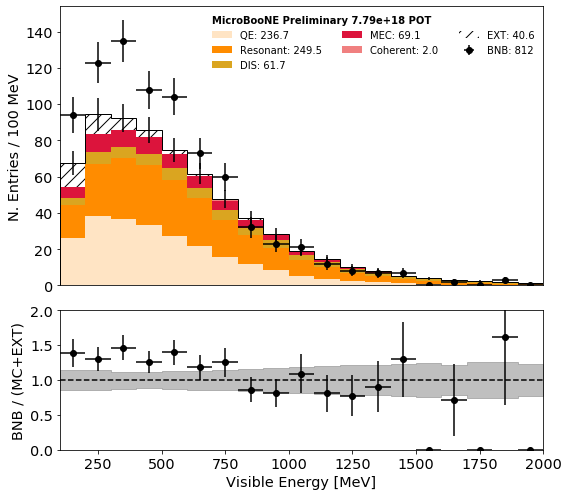

In [27]:
miniboone_bins = [
    0, 0.200, 0.300, 0.375, 0.475, 0.550, 0.675, 0.800, 0.950, 1.100, 1.300,
    1.500, 3.000
]

asymm_bins = [0,500,1000,2000,4000,10000]

VARIABLE, BINS, RANGE, XTIT = 'NeutrinoEnergy2',19,(100,2000),"Visible Energy [MeV]"
#VARIABLE, BINS, RANGE, XTIT = 'pi0_mass_Y',20,(0,500),"pi0 mass Y"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query=QUERY,
    #kind="event_category",
    kind="interaction",
    #kind="sample",
    #kind='particle_pdg',
    draw_sys=True,
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)

print("Profile likelihood: %.2f sigma @ 1.32e21 POT" % my_plotter.significance_likelihood)
print("s/sqrt(b): %.2f sigma @ 1.32e21 POT" % my_plotter.significance)

#ax1.set_ylim(0,20)
#ax1.set_yscale("log")
#ax1.set_ylim(0,0.25)
#ax2.set_ylim(0.5,1.5)
#fig.savefig(ls.plots_path+"spectrum.pdf")

In [ ]:
QUERY += ' and reco_e > 0.2 and reco_e < 0.8'
plots = []
plots.append(['tksh_distance',20,(0,10),"tksh distance"])
plots.append(['shr_tkfit_dedx_Y',20,(0,10),"shr_tkfit_dedx Y"])
plots.append(['tksh_angle',20,(-1,1),"tksh angle"])
plots.append(['trkfit',20,(0,1),"trk fit"])
plots.append(['shrmoliereavg',10,(0,20),"shr moliere avg"])
plots.append(['trkpid',20,(-3,3),"tk pid"])
plots.append(['n_showers_contained',10,(0,10),"n showers contained"])
plots.append(['shr_score',20,(0,0.5),"shr score"])
plots.append(['hits_ratio',20,(0,1),"hits ratio"])
plots.append(['slclustfrac',20,(0,1),"slice clustered fraction"])
plots.append(['CosmicIP',20,(0,200),"Cosmic IP"])
plots.append(['reco_nu_vtx_x',20,(0,260),"x"])
plots.append(['reco_nu_vtx_y',20,(-120,120),"y"])
plots.append(['reco_nu_vtx_z',20,(0,1100),"z"])
plots.append(['reco_e_rqe',20,(0,1),"rqe"])
plots.append(['trkshrhitdist2',20,(0,10),"tksh distance 2d"])
plots.append(['subcluster',20,(0,50),"N shower subcluster"])
plots.append(['shrmoliererms',10,(0,5000),"shr moliere rms"])
plots.append(['shr_energy_tot_cali',20,(0,1),"shr_energy_tot cali"])
plots.append(['contained_fraction',20,(0.,1),"contained fraction"])
plots.append(['cc_score',40,(0.8,1),"cc score"])
plots.append(['cosmic_score',40,(0.8,1),"cosmic score"])
plots.append(['ext_score',40,(0.8,1),"ext score"])
plots.append(['ccpi0_score',40,(0.8,1),"ccpi0 score"])
plots.append(['ncpi0_score',40,(0.8,1),"ncpi0 score"])
for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=False,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )
    fig.show()


In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
import matplotlib.pyplot as plt

BINS = np.linspace(0,1,25)
VAR = 'cosmic_score'

nueplot = nue.query(QUERY)
nueplotecut = nueplot.query('nu_e < 0.8')

fig = plt.figure(figsize=(6,6))
plt.hist(nueplot[VAR].values,bins=BINS,histtype='step',lw=2,color='red',label='all nue')
plt.hist(nueplotecut[VAR].values,bins=BINS,histtype='step',lw=2,color='m',label='nue < 0.8 GeV')
#plt.hist(nue[VAR].values,bins=BINS,histtype='step',lw=2,color='green')
plt.grid()
plt.legend()
plt.title(VAR)
plt.show()

BINS2D = (np.linspace(0,3.0,25),BINS)

fig = plt.figure(figsize=(6,6))
plt.hist2d(nueplot['nu_e'].values,nueplot[VAR].values,bins=BINS2D)
#plt.hist(nue[VAR].values,bins=BINS,histtype='step',lw=2,color='green')
plt.grid()
plt.show()

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
import matplotlib.pyplot as plt

x_range = (0.1,0.8)
n_bins = 7

n_tot = np.empty([50, n_bins])
n_cv_tot = np.empty(n_bins)
n_tot.fill(0)
n_cv_tot.fill(0)
score_cut = 0.997

my_cmap = cm.get_cmap('viridis')

for t in samples:
    if t in ["ext", "data", "lee"]:
        continue
    tree = samples[t]
    
    extra_query = ""
    if t == "mc":
        extra_query = "& ~(nu_pdg == 12 & ccnc == 0) & ~(npi0 != 0 & ccnc == 1)"
        
    queried_tree = tree.query("selected==1 & global_score > %g %s & interaction == 1" % (score_cut, extra_query))
    variable = queried_tree["reco_e"]
    genie_weights = queried_tree["weightsGenie"]
    spline_fix = queried_tree["weightSpline"]*weights[t]

    s = genie_weights
    df = pd.DataFrame(s.values.tolist())


    n_cv, bins = np.histogram(
        variable,
        range=x_range,
        bins=n_bins,
        weights=spline_fix)
    
    n_cv_tot += n_cv

    if not df.empty:
        for i in range(50):
            weight = df[i].values
            weight[np.isnan(weight)] = 1
            weight[weight > 100] = 1

            n, bins = np.histogram(
                variable, weights=weight*spline_fix, range=x_range, bins=n_bins)

            n_tot[i] += n

        
bincenters = 0.5 * (bins[1:] + bins[:-1])

left,right = bins[:-1],bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([n_cv_tot,n_cv_tot]).T.flatten()
plt.plot(X,Y,color='r',linewidth=2,label='Central value')

    
cov = np.empty([len(n_cv), len(n_cv)])
cov.fill(0)

my_norm = Normalize(vmin=min((sum(n) for n in n_tot)), vmax=max((sum(n) for n in n_tot)))

for n in n_tot:
    left,right = bins[:-1],bins[1:]
    X = np.array([left,right]).T.flatten()
    Y = np.array([n,n]).T.flatten()
    plt.plot(X,Y,color=my_cmap(my_norm(sum(n))),zorder=-32)
    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

cov /= 50
            
frac_cov = np.empty([len(n_cv), len(n_cv)])
corr = np.empty([len(n_cv), len(n_cv)])

for i in range(len(n_cv)):
    for j in range(len(n_cv)):
        frac_cov[i][j] = cov[i][j] / (n_cv_tot[i] * n_cv_tot[j])
        corr[i][j] = cov[i][j] / np.sqrt(cov[i][i] * cov[j][j])

        
plt.errorbar(
    bincenters, 
    n_cv_tot,
    yerr=np.sqrt(np.diag(cov)), 
    fmt='none', 
    ecolor='r',
    linewidth=2,
    label='GENIE sys. uncertainties')

print(np.sqrt(np.diag(cov))/n_cv_tot)
plt.xlim(x_range[0], x_range[1])
plt.xlabel(r"$E_{deposited}$ [GeV]")
plt.legend()
plt.ylim(ymin=0)
plt.tight_layout()
plt.savefig("plots/spec.pdf", transparent=True)

In [ ]:
fig, ax = plt.subplots(1, 1)
pos = ax.imshow(frac_cov, origin='lower', cmap='viridis')
ax.set_title("Fractional covariance matrix")
ax.set_ylabel("Bin number")
ax.set_xlabel("Bin number")
fig.colorbar(pos)
fig.tight_layout()
fig.savefig("plots/frac.pdf", transparent=True)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Correlation matrix")
pos = ax.imshow(corr, origin='lower', cmap='inferno')
ax.set_ylabel("Bin number")
ax.set_xlabel("Bin number")
fig.colorbar(pos)
fig.tight_layout()
fig.savefig("plots/corr.pdf", transparent=True)

In [ ]:
my_plotter.plot_2d(
    "global_score",
    "ncpi0_score",
    query="selected==1",
    bins_x=50,
    bins_y=50,
    range_x=(0., 1),
    range_y=(0., 1))